### CNN on CIFR Assignment:

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
import keras

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from keras import models, layers
from keras.models import Model
from keras.layers import BatchNormalization, Activation, Flatten
from keras.optimizers import Adam
from matplotlib import pyplot
from scipy.misc import toimage
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import optimizers
from tensorflow import keras
from keras import backend as k
import tensorflow as tf

Using TensorFlow backend.


In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

#from tensorflow import keras

#from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
#import tensorflow as tf

#tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))

#tf.config.gpu_options.set_per_process_memory_fraction(0.75)
#tf.config.gpu_options.set_per_process_memory_growth(True)

#config = tf.ConfigProto()

#config.gpu_options.allow_growth = True

#config.gpu_options.per_process_gpu_memory_fraction
#sess = tf.Session(config=config)

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.75
#session = tf.Session(config=config, ...)

# Create a session with the above options specified.
#k.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 100
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]



In [5]:
print("Shape of train Dataset",X_train.shape)
print("*"*125)
print("Shape of test Dataset",X_test.shape)

Shape of train Dataset (50000, 32, 32, 3)
*****************************************************************************************************************************
Shape of test Dataset (10000, 32, 32, 3)


# Some Test Images

C:\Users\MERCER\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


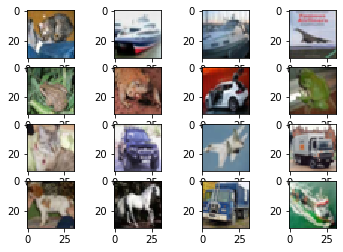

In [6]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
show_imgs(X_test[:16])

In [7]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    
    )
datagen.fit(X_train,augment=True, rounds=3)

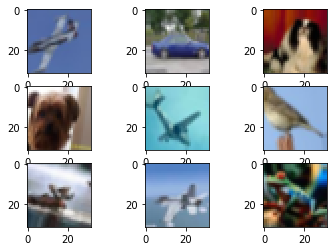

In [8]:
import matplotlib.pyplot as plt
import numpy as np
# see example augmentation images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [9]:
#reshape into images

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, channel)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, channel)
input_shape = (img_height, img_width, 1)
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:

#convert integers to float; normalise and center the mean
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)
X_test=(X_test-mean)/std
X_train=(X_train-mean)/std

In [11]:
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [12]:
# plotting epoch vs accuracy
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [14]:
num_filter = 12
dropout_rate = 0.2
l = 40

reg=l2(1e-4)   # L2 or "ridge" regularisation
#reg = None

ac='relu'

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3),activation = ac,kernel_initializer = 'he_normal' ,kernel_regularizer =reg , use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# training without augmentation

In [16]:
# determine Loss function and Optimizer
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
#adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#opt=adm

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
# train without image augmentation
#history=model.fit(X_train, y_train, batch_size=128, epochs=300,verbose=5, validation_data=(X_test, y_test))

In [19]:
# train with image augmentation
history1=model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train) / 32, epochs=100, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1563/1562 [==============================] - 864s 553ms/step - loss: 1.8465 - acc: 0.3250 - val_loss: 1.7283 - val_acc: 0.3941
Epoch 2/100
1563/1562 [==============================] - 806s 516ms/step - loss: 1.5135 - acc: 0.4416 - val_loss: 1.4774 - val_acc: 0.4813
Epoch 3/100
1563/1562 [==============================] - 803s 514ms/step - loss: 1.3518 - acc: 0.5081 - val_loss: 1.2662 - val_acc: 0.5551
Epoch 4/100
1563/1562 [==============================] - 806s 515ms/step - loss: 1.2496 - acc: 0.5468 - val_loss: 1.2709 - val_acc: 0.5751
Epoch 5/100
1563/1562 [==============================] - 805s 515ms/step - loss: 1.1630 - acc: 0.5832 - val_loss: 1.1488 - val_acc: 0.6213
Epoch 6/100
1563/1562 [==============================] - 803s 514ms/step - loss: 1.0926 - acc: 0.6086 - val_loss: 1.6233 - val_acc: 0.5339
Epoch 7/100
1563/1562 [==============================] - 803s 514ms/step - loss: 1.0426 - acc: 0.6292 - val_loss: 1.05

In [20]:
# save model and architecture to single file
model.save("model_100_epoch1.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
#training accuracy without dropout
train_acc=model.evaluate(X_train,y_train,batch_size=30)
print("%s: %.2f%%" % (model.metrics_names[1], train_acc[1]*100))

50000/50000 [==============================] - 216s 4ms/step
acc: 85.94%


In [22]:
# save model and architecture to single file
model.save("model_100_epoch.h5")
print("Saved model to disk")

Saved model to disk


In [23]:
#training accuracy without dropout
train_acc=model.evaluate(X_test,y_test,batch_size=30)
print("%s: %.2f%%" % (model.metrics_names[1], train_acc[1]*100))

10000/10000 [==============================] - 43s 4ms/step
acc: 82.32%


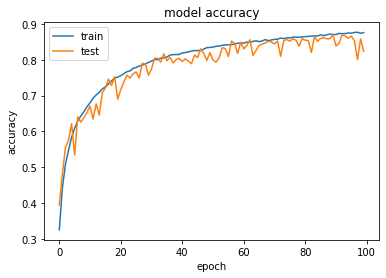

In [25]:
# Plot Accuracy
plothist(history1)

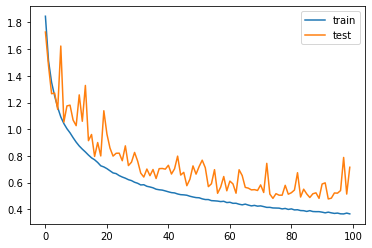

In [31]:
# plot Loss
pyplot.plot(history1.history['loss'], label='train')
pyplot.plot(history1.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [26]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('model_100_epoch.h5')

In [27]:
# summarize model.
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [33]:
# Define CallBacks

# patient early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [34]:
# ModelChackpoint

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [35]:
# train with image augmentation on Further 100 epochs after load_model('model_100_epoch.h5')
history2 = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train) / 32, epochs=100, validation_data=(X_test, y_test),callbacks=[es, mc])

Epoch 1/100
1563/1562 [==============================] - 819s 524ms/step - loss: 0.3657 - acc: 0.8760 - val_loss: 0.5551 - val_acc: 0.8531

Epoch 00001: val_acc improved from -inf to 0.85310, saving model to best_model.h5
Epoch 2/100
1563/1562 [==============================] - 803s 514ms/step - loss: 0.3596 - acc: 0.8776 - val_loss: 0.5467 - val_acc: 0.8523

Epoch 00002: val_acc did not improve from 0.85310
Epoch 3/100
1563/1562 [==============================] - 800s 512ms/step - loss: 0.3600 - acc: 0.8775 - val_loss: 0.5230 - val_acc: 0.8563

Epoch 00003: val_acc improved from 0.85310 to 0.85630, saving model to best_model.h5
Epoch 4/100
1563/1562 [==============================] - 804s 514ms/step - loss: 0.3583 - acc: 0.8794 - val_loss: 0.4728 - val_acc: 0.8707

Epoch 00004: val_acc improved from 0.85630 to 0.87070, saving model to best_model.h5
Epoch 5/100
1563/1562 [==============================] - 800s 512ms/step - loss: 0.3561 - acc: 0.8777 - val_loss: 0.5913 - val_acc: 0.8455

1563/1562 [==============================] - 804s 515ms/step - loss: 0.3123 - acc: 0.8944 - val_loss: 0.4314 - val_acc: 0.8828

Epoch 00043: val_acc did not improve from 0.88990
Epoch 44/100
1563/1562 [==============================] - 804s 515ms/step - loss: 0.3124 - acc: 0.8946 - val_loss: 0.4945 - val_acc: 0.8658

Epoch 00044: val_acc did not improve from 0.88990
Epoch 00044: early stopping


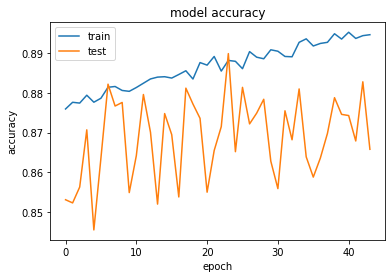

In [36]:
# Plot Accuracy
plothist(history2)

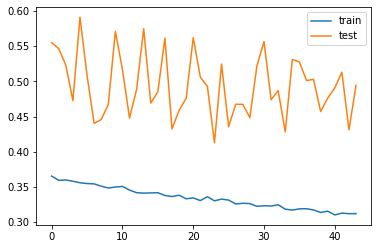

In [37]:
# plot Loss
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# load the saved model
model_1 = load_model('best_model.h5')
# evaluate the model
_, train_acc = model_1.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_1.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.932, Test: 0.890


In [40]:
# ModelChackpoint

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_new.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [41]:
# train with image augmentation on Further 100 epochs after load_model('best_model.h5')
history3 = model_1.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train) / 32, epochs=100, validation_data=(X_test, y_test),callbacks=[mc])

Epoch 1/100
1563/1562 [==============================] - 837s 535ms/step - loss: 0.3316 - acc: 0.8873 - val_loss: 0.4380 - val_acc: 0.8792

Epoch 00001: val_acc improved from -inf to 0.87920, saving model to best_model_new.h5
Epoch 2/100
1563/1562 [==============================] - 812s 520ms/step - loss: 0.3295 - acc: 0.8889 - val_loss: 0.4505 - val_acc: 0.8826

Epoch 00002: val_acc improved from 0.87920 to 0.88260, saving model to best_model_new.h5
Epoch 3/100
1563/1562 [==============================] - 816s 522ms/step - loss: 0.3266 - acc: 0.8897 - val_loss: 0.4920 - val_acc: 0.8705

Epoch 00003: val_acc did not improve from 0.88260
Epoch 4/100
1563/1562 [==============================] - 821s 525ms/step - loss: 0.3276 - acc: 0.8888 - val_loss: 0.4459 - val_acc: 0.8769

Epoch 00004: val_acc did not improve from 0.88260
Epoch 5/100
1563/1562 [==============================] - 817s 523ms/step - loss: 0.3226 - acc: 0.8906 - val_loss: 0.5411 - val_acc: 0.8618

Epoch 00005: val_acc did 

1563/1562 [==============================] - 816s 522ms/step - loss: 0.2580 - acc: 0.9122 - val_loss: 0.4806 - val_acc: 0.8799

Epoch 00086: val_acc did not improve from 0.89800
Epoch 87/100
1563/1562 [==============================] - 816s 522ms/step - loss: 0.2623 - acc: 0.9111 - val_loss: 0.4863 - val_acc: 0.8802

Epoch 00087: val_acc did not improve from 0.89800
Epoch 88/100
1563/1562 [==============================] - 816s 522ms/step - loss: 0.2586 - acc: 0.9129 - val_loss: 0.4528 - val_acc: 0.8870

Epoch 00088: val_acc did not improve from 0.89800
Epoch 89/100
1563/1562 [==============================] - 816s 522ms/step - loss: 0.2607 - acc: 0.9115 - val_loss: 0.4704 - val_acc: 0.8816

Epoch 00089: val_acc did not improve from 0.89800
Epoch 90/100
1563/1562 [==============================] - 816s 522ms/step - loss: 0.2580 - acc: 0.9125 - val_loss: 0.4195 - val_acc: 0.8895

Epoch 00090: val_acc did not improve from 0.89800
Epoch 91/100
1563/1562 [==============================] - 

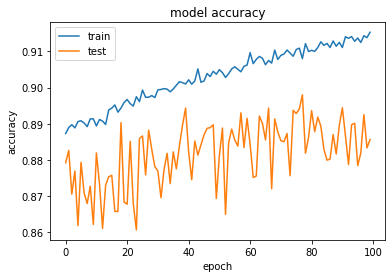

In [42]:
# Plot Accuracy
plothist(history3)

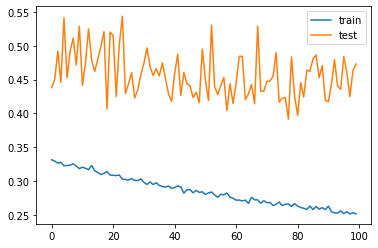

In [43]:
# plot Loss
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [18]:
# load the saved model
model_2 = load_model('best_model_new.h5')
# evaluate the model
_, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Instructions for updating:
Use tf.cast instead.
Train: 0.949, Test: 0.898


In [19]:
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 12)   48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 12)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [20]:
# ModelChackpoint

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('final_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [21]:
# train with image augmentation on Further 100 epochs after load_model('best_model.h5')
history3 = model_2.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch = len(X_train) / 32, epochs=56, validation_data=(X_test, y_test),callbacks=[mc])

Epoch 1/56
1563/1562 [==============================] - 834s 533ms/step - loss: 0.2661 - acc: 0.9097 - val_loss: 0.4453 - val_acc: 0.8874

Epoch 00001: val_acc improved from -inf to 0.88740, saving model to final_model.h5
Epoch 2/56
1563/1562 [==============================] - 812s 520ms/step - loss: 0.2655 - acc: 0.9096 - val_loss: 0.4433 - val_acc: 0.8897

Epoch 00002: val_acc improved from 0.88740 to 0.88970, saving model to final_model.h5
Epoch 3/56
1563/1562 [==============================] - 815s 521ms/step - loss: 0.2560 - acc: 0.9137 - val_loss: 0.4172 - val_acc: 0.8932

Epoch 00003: val_acc improved from 0.88970 to 0.89320, saving model to final_model.h5
Epoch 4/56
1563/1562 [==============================] - 815s 522ms/step - loss: 0.2578 - acc: 0.9111 - val_loss: 0.4530 - val_acc: 0.8847

Epoch 00004: val_acc did not improve from 0.89320
Epoch 5/56
1563/1562 [==============================] - 809s 517ms/step - loss: 0.2630 - acc: 0.9106 - val_loss: 0.4315 - val_acc: 0.8925



1563/1562 [==============================] - 810s 518ms/step - loss: 0.2435 - acc: 0.9164 - val_loss: 0.4222 - val_acc: 0.8939

Epoch 00043: val_acc did not improve from 0.90220
Epoch 44/56
1563/1562 [==============================] - 817s 523ms/step - loss: 0.2429 - acc: 0.9164 - val_loss: 0.4313 - val_acc: 0.8940

Epoch 00044: val_acc did not improve from 0.90220
Epoch 45/56
1563/1562 [==============================] - 813s 520ms/step - loss: 0.2437 - acc: 0.9179 - val_loss: 0.4518 - val_acc: 0.8890

Epoch 00045: val_acc did not improve from 0.90220
Epoch 46/56
1563/1562 [==============================] - 820s 524ms/step - loss: 0.2384 - acc: 0.9190 - val_loss: 0.4525 - val_acc: 0.8830

Epoch 00046: val_acc did not improve from 0.90220
Epoch 47/56
1563/1562 [==============================] - 819s 524ms/step - loss: 0.2383 - acc: 0.9196 - val_loss: 0.4157 - val_acc: 0.8949

Epoch 00047: val_acc did not improve from 0.90220
Epoch 48/56
1563/1562 [==============================] - 814s 

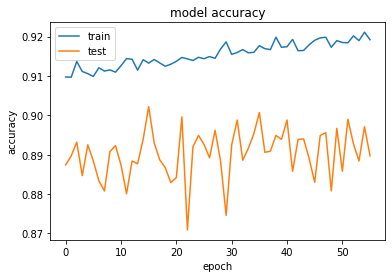

In [22]:
# Plot Accuracy
plothist(history3)

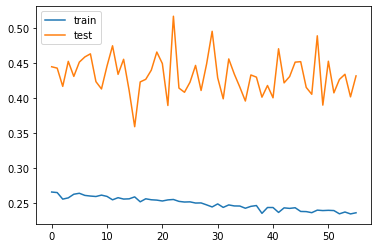

In [23]:
# plot Loss
pyplot.plot(history3.history['loss'], label='train')
pyplot.plot(history3.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
# load the saved model
model_2 = load_model('final_model.h5')
# evaluate the model
_, train_acc = model_2.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_2.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.954, Test: 0.902
